# Calculation of unlensed and lensed rate of detectable events (Pop III)

## BBH/BNS merger rate density wrt to redshift
* merger rate as given in https://arxiv.org/pdf/2012.09876.pdf (C15): 
$$ \mathcal{R}_m(z_s) = \frac{e^{a_{III}(z_s-z_{III})}}{b_{III}+\alpha_{III}e^{(\alpha_{III}+b_{III})(z_s-z_{III})}} \text{Gpc}^{-3}\text{yr}^{-1}$$
* $z_s$: redshift of source
* $\mathcal{R}_O$: local mergerrate. $\mathcal{R}_O=\mathcal{R}_m(z_s=0)$
* fitting parameters: $\alpha_{III}=0.66$, $b_{III}=0.3$, $z_{III}=11.6$

## BBH/BNS merger rate at source redshift $z_s$ (in small dz)
$$ R(z_s) = \frac{\mathcal{R}_m(z_s)}{1+z_s} \frac{dV_c}{dz_s} $$
* co-moving volume : $\frac{dV_c}{dz_s}$

* sampling of $z_s$ is done through rejection sampling with the merger rate formula given above

In [1]:
import numpy as np
from ler import LeR
from ler import SourceGalaxyPopulationModel
from astropy.cosmology import Planck18
from ler.helperroutines import rejection_sample
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
ler_ = LeR(npool=4,z_min=0., z_max=20.,snr_type = 'interpolation', \
           waveform_inspiral_must_be_above_fmin=False,\
          psds={'CE':'CosmicExplorerP1600143','ET':'EinsteinTelescopeP1600143'})

Given: IMR waveform
given psds:  {'CE': 'CosmicExplorerP1600143', 'ET': 'EinsteinTelescopeP1600143'}
Interpolator will be generated for CE detector at ./interpolator_pickle/CE/halfSNR_dict_0.pickle
Interpolator will be generated for ET detector at ./interpolator_pickle/ET/halfSNR_dict_0.pickle
Generating interpolator for ['CE', 'ET'] detectors


interpolation for each mass_ratios: 100%|███████████████████████████| 50/50 [01:14<00:00,  1.50s/it]

interpolator generated


In [3]:
differential_comoving_volume = ler_.compact_binary_pop.differential_comoving_volume
normalization_pdf_z = ler_.compact_binary_pop.normalization_pdf_z

In [10]:
def merger_rate_density_primordial(zs, t0=13.786885302009708):
    '''
    Function to compute the merger rate density
    '''
    rate_density = (Planck18.age(z=zs).value/t0)**(-34/37)
    return rate_density

def merger_rate_density_popI_II_Madau_Dickinson(zs, af=2.7,bf=5.6,cf=1.9):
        '''
        Function to compute the merger rate density (PopI/PopII)
        Input parameters:
            zs (float/array): source redshifts
            R0 (float)      : normalization constant [default: 23.9*1e-9]
            b2 (float)      : fitting paramters [default: 1.6]
            b3 (float)      : fitting paramters [default: 2.0]
            b4 (float)      : fitting paramters [default: 30]
        Output parameters:
            rate_density (float/array): merger rate density (Mpc^-3 yr^-1)
        '''
        rate_density = (1+zs)**af / (1 + ((1+zs)/cf)**bf)
        return rate_density 

def merger_rate_density_popIII(zs, aIII=0.66, bIII=0.3, zIII=11.6):
    '''
    Function to compute the merger rate density
    '''
    rate_density = np.exp(aIII*(zs-zIII))/(bIII + aIII*np.exp((aIII+bIII)*(zs-zIII)))
    return rate_density

def sample_source_redshifts(size=1000, z_min=0., z_max=12.):
    '''
    Function to sample source redshifts from the source galaxy population model
    Input parameters:
        size (int): number of source redshifts to sample
        z_min (float): minimum redshift of the source population
        z_max (float): maximum redshift of the source population
    Output parameters:
        zs (array): array of source redshifts
    '''
    # Define the merger-rate density function
    merger_rate_density_detector_frame = lambda z:  merger_rate_density_primordial(z)/(1+z) 
    # Define the pdf p(z)
    pdf_unnormalized = lambda z: merger_rate_density_detector_frame(z) * differential_comoving_volume(z)
    # Normalize the pdf
    normalization = normalization_pdf_z
    pdf = lambda z: pdf_unnormalized(z) / normalization
    # Sample the redshifts using rejection sampling
    zs = rejection_sample(pdf, z_min, z_max, size=size)
    return zs

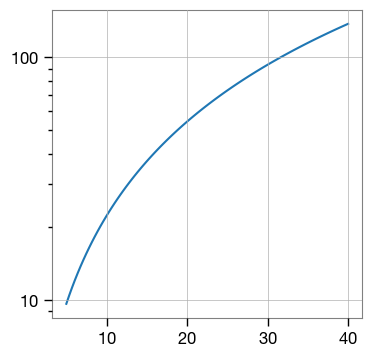

In [9]:
zs = np.linspace(5,40,100)
plt.plot(zs, merger_rate_density_primordial(zs))
plt.yscale('log')
plt.show()

In [11]:
primordial = sample_source_redshifts(size=10000, z_min=5., z_max=40.)

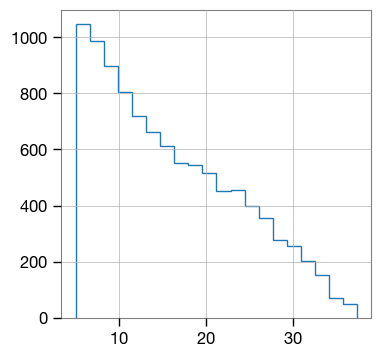

In [13]:
plt.hist(primordial, histtype='step', bins=20)
#plt.yscale('log')
plt.show()

In [14]:
merger_rate_density_detector_frame = lambda z:  merger_rate_density_primordial(z)/(1+z) 
# Define the pdf p(z)
pdf_unnormalized = lambda z: merger_rate_density_detector_frame(z) * differential_comoving_volume(z)
# Normalize the pdf
normalization = normalization_pdf_z
pdf = lambda z: pdf_unnormalized(z) / normalization

In [29]:
dVcdz = Planck18.differential_comoving_volume(zs).value

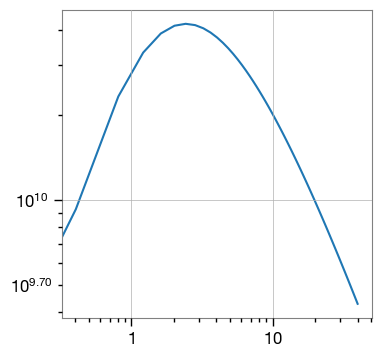

In [30]:
zs = np.linspace(0,40,100)
plt.plot(zs, dVcdz)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [131]:
merger_rate_density = merger_rate_density_popIII
zpopIII = sample_source_redshifts(size=100000, z_min=5., z_max=40.)

In [137]:
merger_rate_density = merger_rate_density_popI_II_Madau_Dickinson
zpopI_II = ler_.compact_binary_pop.sample_source_redshifts(size=100000, z_min=5., z_max=40.)
zpopI_II2 = sample_source_redshifts(size=100000, z_min=5., z_max=40.)

In [154]:
merger_rate_density = merger_rate_density_primordial
primordial = sample_source_redshifts(size=100000, z_min=5., z_max=40.)

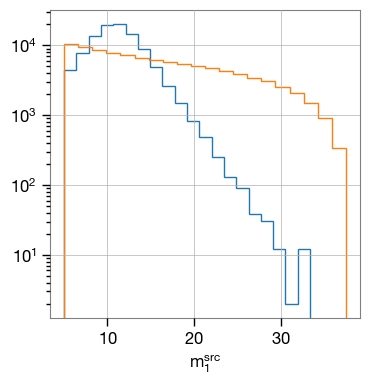

In [155]:
plt.hist(zpopIII, histtype='step', bins=20)
#plt.hist(zpopI_II, histtype='step', bins=20)
#plt.hist(zpopI_II2, histtype='step', bins=20)
plt.hist(primordial, histtype='step', bins=20)
plt.yscale('log')
plt.show()

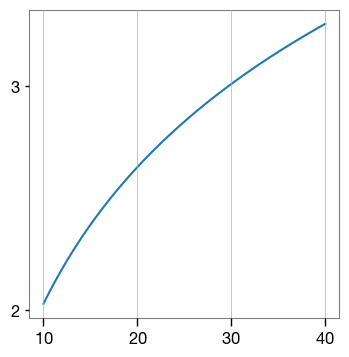

In [19]:
x_ = np.linspace(10,40,100)
y_ = (Planck18.age(z=x_).value/Planck18.age(z=0).value)**(-34/37) / (1+x_)
#y_ = merger_rate_density_popIII(x_)
plt.plot(x_,y_)
plt.yscale('log')

In [ ]:
# primordial

In [1]:
import numpy as np
from ler import CompactBinaryPopulation
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
ler_ = CompactBinaryPopulation(z_min=0., z_max=20., event_type='primordial')

In [3]:
popI_II = ler_.sample_source_redshifts(size=10000, z_min=0., z_max=20)

In [21]:
popIII = ler_.sample_source_redshifts(size=10000, z_min=0., z_max=20)

In [18]:
primordial = ler_.sample_source_redshifts(size=10000, z_min=0., z_max=20)

In [14]:
ler_.z_max

20.0

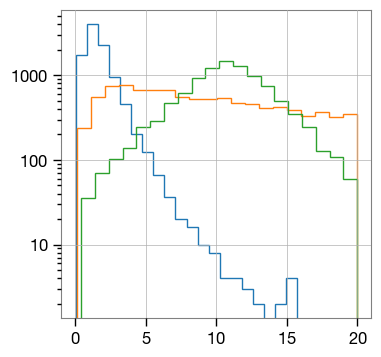

In [25]:
plt.hist(popI_II, histtype='step', bins=20)a
plt.hist(primordial, histtype='step', bins=20)
plt.hist(popIII, histtype='step', bins=20)
plt.yscale('log')
plt.show()

In [4]:
sample = ler_.sample_gw_parameters(nsamples=10000)

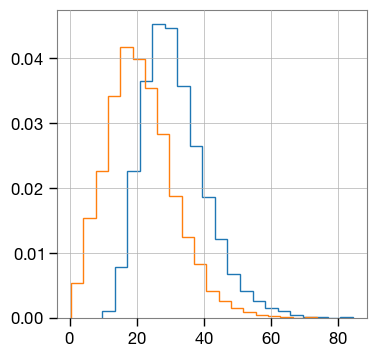

In [7]:
plt.hist(sample['mass_1_source'], histtype='step', bins=20, density=True)
plt.hist(sample['mass_2_source'], histtype='step', bins=20, density=True)
plt.show()

# function replacement

In [21]:
ler_.compact_binary_pop.merger_rate_density_popIII=merger_rate_density_popIII

In [ ]:
def binary_masses_popI_II(self, size, model_pars):
    """
    Function to calculate source mass1 and mass2 with PowerLaw+PEAK model 
    """
    
    model = p.mass_prior('BBH-powerlaw-gaussian', model_pars)
    mass_1_source, mass_2_source = model.sample(Nsample=size)
    while np.any(mass_2_source>mass_1_source):
        mass_1_source, mass_2_source = model.sample(Nsample=nsamples)
    
    return(mass_1_source,mass_2_source)

In [63]:
def test(x, **kwargs):
    try: 
        kwargs['a']
        kwargs['b']
        print(kwargs)
    except:
        print(x)

In [65]:
test(x=1, a=2)

1


In [62]:
{'a':None,}

{'a': None}

In [12]:
from ler.helperroutines import rejection_sample, rejection_sample2d 

In [16]:
def binary_masses_primordial(size, model_pars={'Mc':30.,'sigma':0.3}):
    """
    Function to calculate source mass1 and mass2 with PowerLaw+PEAK model 
    """
    
    Mc = model_pars['Mc']
    sigma = model_pars['sigma']
    q = mass_ratio(size)
    pdf = lambda m: np.exp(-np.log(m/Mc)**2 / (2*sigma**2)) / (np.sqrt(2*np.pi)*sigma*m)
    mass_1_source = rejection_sample(pdf, 5, 100, size=size)
    mass_2_source = q*mass_1_source

    return(mass_1_source,mass_2_source)

def mass_ratio(size, beta=1.1):
    pdf = lambda q: q**beta
    q = rejection_sample(pdf, 0, 1, size=size)
    return(q)

In [17]:
m1,m2 = binary_masses_primordial(1000)

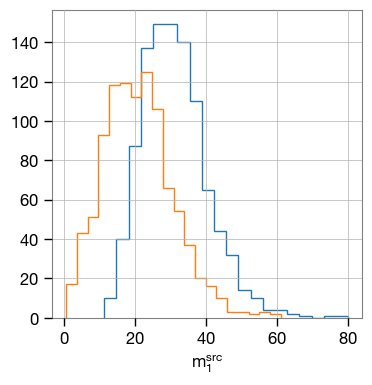

In [18]:
plt.hist(m1, histtype='step', bins=20)
plt.hist(m2, histtype='step', bins=20)
plt.xlabel(r'$m_1^{src}$')
#plt.yscale('log')
plt.show()

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
m_min=4.59
m_max=86.22
param = dict( Mc=30.0, sigma=0.3, beta=1.1 )
psi = lambda m: np.exp(-np.log(m / param["Mc"]) ** 2 / (2 * param["sigma"]**2)) / (
            np.sqrt(2 * np.pi) * param["sigma"] * m
        )

m_1 = np.linspace(m_min, m_max, 200)
m_2 = np.linspace(m_min, m_max, 200)
m1, m2 = np.meshgrid(m_1, m_2)
pdf = lambda m1,m2: (m1+m2)**(36/37) * (m1*m2)**(32/37) * psi(m1) * psi(m2)
#f = interpolate.interp2d(m1, m2, pdf, kind='cubic')

In [10]:
mass_1, mass_2 = rejection_sample2d(pdf=pdf, xmin=m_min, xmax=m_max, ymin=m_min, ymax=m_max, size=100)
idx = mass_2>mass_1
mass_1[idx], mass_2[idx] = mass_2[idx], mass_1[idx]

In [7]:
def rejection_sample2d(pdf, xmin, xmax, ymin, ymax, size=100):
    
    chunk_size = 10000
    
    x = np.linspace(xmin, xmax, 1000)
    y = np.linspace(ymin, ymax, 1000)
    z = pdf(x,y)
    zmax = np.max(z)
    
    
    # Rejection sample in chunks
    x_sample = []
    y_sample = []
    while len(x_sample) < size:
        x_try = np.random.uniform(xmin, xmax, size=chunk_size)
        y_try = np.random.uniform(ymin, ymax, size=chunk_size)
        
        z_try = np.random.uniform(0, zmax, size=chunk_size)
        zmax = max(zmax, np.max(z_try))

        x_sample += list(x_try[z_try < pdf(x_try, y_try)])
        y_sample += list(y_try[z_try < pdf(x_try, y_try)])
        
    # Transform the samples to a 1D numpy array
    x_sample = np.array(x_sample).flatten()
    y_sample = np.array(y_sample).flatten()
    # Return the correct number of samples
    return x_sample[:size], y_sample[:size]

In [2]:
import ler

In [3]:
ler_ = ler.CompactBinaryPopulation(event_type="primordial")

In [4]:
ler_.binary_masses_primordial(size=10)

(array([36.91189232, 55.58785031, 32.94282517, 32.40992142,
        39.90565265, 34.41200859, 31.43073187, 34.70431827,
        30.38195077, 53.45406331]),
 array([23.77520962, 39.02193828, 28.68093086, 25.37977097,
        34.60843988, 22.13928014, 25.15593115, 30.20126566,
        21.83535191, 28.32737683]))